In [1]:
from dotenv import load_dotenv
import os
import pandas as pd
import math
import json
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from torch.optim import AdamW
from torch.amp import autocast
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, log_loss

load_dotenv()

In [8]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [4]:
os.environ["HF_HOME"] = os.getenv("HF_HOME")
os.environ["HF_HOME"]

'/media/luna/huggingface'

In [5]:
DATA_DIR = os.getenv("DATA_DIR")
DATA_DIR

'data'

In [6]:
MODELS_DIR = os.getenv("MODELS_DIR")
MODELS_DIR

'models'

In [24]:
STATISTIC_DIR = os.getenv("STATISTIC_DIR")
STATISTIC_DIR

'statistic'

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='cuda')

In [10]:
train_data = pd.read_json(os.path.join(DATA_DIR, 'data_final_for_dls_new.jsonl'), orient='orient', lines=True)[570:]
train_data = train_data[train_data['relevance'] != 0.1]
train_data = train_data.fillna("")
train_data

,Text,address,name,normalized_main_rubric_name_ru,permalink,prices_summarized,relevance,reviews_summarized,relevance_new
570,налоговая 5007,"Московская область, Королёв, улица Богомолова, 4",Налоговая служба; Межрайонная ИФНС № 2; ИФНС №...,Налоговая инспекция,1377658436,,0.0,Организация занимается обслуживанием налогопла...,0.0
571,шугаринг Красноярск,"Красноярск, микрорайон Взлётка, улица Весны, 3",Студия красоты Дарлинг; Darling; Дарлинг,Салон красоты,1085001465,Студия красоты «Дарлинг» предоставляет услуги ...,1.0,Студия красоты «Дарлинг» предоставляет бьюти-у...,1.0
573,новогодняя ночь 2018 в ресторане,"Москва, Кутузовский проспект, 36А",Atlantica seafood; Коллекция; Коллекция Food &...,Ресторан,1187477091,Ресторан Atlantica предлагает разнообразные бл...,1.0,Организация занимается ресторанным бизнесом и ...,1.0
574,балетная школа в санкт петербурге 12лет с прож...,"Санкт-Петербург, Невский проспект, 35В",Русская национальная балетная школа Илзе Лиепа...,Школа танцев,172170646460,,0.0,Организация занимается обучением балету и хоре...,0.0
575,солкосерил гель цена,"Москва, Симферопольский бульвар, 29, корп. 1",Столички; Stolichki; Apteki Stolichki,Аптека,226500195223,Аптека «Столички» предлагает широкий спектр ле...,1.0,Организация занимается продажей лекарств и мед...,1.0
...,...,...,...,...,...,...,...,...,...
35089,нотариус запись,"Москва, 15-я Парковая улица, 45",Нотариус О. Н. Савина; Notarius O. N. Savina; ...,Нотариусы,1056199530,,1.0,Организация предоставляет нотариальные услуги ...,1.0
35090,стационар для кота москва,"Москва, улица Госпитальный Вал, 3, корп. 5",ТриоВет; Triovet; Триовет; Veterinaria Triovet,Ветеринарная клиника,133156701339,"Ветеринарная клиника, аптека и лаборатория «Тр...",0.0,"Организация занимается ветеринарными услугами,...",0.0
35091,агзс пропан,"Самара, улица 22-го Партсъезда, 49, корп. 1",Роза Мира; АЗС № 2; Роза мира,АЗС,6884296946,,0.0,Организация занимается заправкой транспортных ...,0.0
35092,где вибрить ваз 2112,"Нижний Новгород, Московское шоссе, 34","Нижегородец, Lada; Nizhegorodec, Lada; Нижегор...",Автосалон,124836381099,Автосалон «Нижегородец» предлагает новые автом...,0.0,Автосалон «Нижегородец» занимается продажей и ...,0.0


In [11]:
X = train_data.drop(columns=['relevance', 'relevance_new', 'address', 'permalink'])
X

,Text,name,normalized_main_rubric_name_ru,prices_summarized,reviews_summarized
570,налоговая 5007,Налоговая служба; Межрайонная ИФНС № 2; ИФНС №...,Налоговая инспекция,,Организация занимается обслуживанием налогопла...
571,шугаринг Красноярск,Студия красоты Дарлинг; Darling; Дарлинг,Салон красоты,Студия красоты «Дарлинг» предоставляет услуги ...,Студия красоты «Дарлинг» предоставляет бьюти-у...
573,новогодняя ночь 2018 в ресторане,Atlantica seafood; Коллекция; Коллекция Food &...,Ресторан,Ресторан Atlantica предлагает разнообразные бл...,Организация занимается ресторанным бизнесом и ...
574,балетная школа в санкт петербурге 12лет с прож...,Русская национальная балетная школа Илзе Лиепа...,Школа танцев,,Организация занимается обучением балету и хоре...
575,солкосерил гель цена,Столички; Stolichki; Apteki Stolichki,Аптека,Аптека «Столички» предлагает широкий спектр ле...,Организация занимается продажей лекарств и мед...
...,...,...,...,...,...
35089,нотариус запись,Нотариус О. Н. Савина; Notarius O. N. Savina; ...,Нотариусы,,Организация предоставляет нотариальные услуги ...
35090,стационар для кота москва,ТриоВет; Triovet; Триовет; Veterinaria Triovet,Ветеринарная клиника,"Ветеринарная клиника, аптека и лаборатория «Тр...","Организация занимается ветеринарными услугами,..."
35091,агзс пропан,Роза Мира; АЗС № 2; Роза мира,АЗС,,Организация занимается заправкой транспортных ...
35092,где вибрить ваз 2112,"Нижегородец, Lada; Nizhegorodec, Lada; Нижегор...",Автосалон,Автосалон «Нижегородец» предлагает новые автом...,Автосалон «Нижегородец» занимается продажей и ...


In [12]:
# Объединение текстовых полей
def combine_fields(row):
    return f"Запрос: {row['Text']} | Название: {row['name']} | Рубрика: {row['normalized_main_rubric_name_ru']} | Описание: {row['prices_summarized']} | Отзывы: {row['reviews_summarized']}"

In [13]:
X['combined_fields'] = X.apply(combine_fields, axis=1)
X

,Text,name,normalized_main_rubric_name_ru,prices_summarized,reviews_summarized,combined_fields
570,налоговая 5007,Налоговая служба; Межрайонная ИФНС № 2; ИФНС №...,Налоговая инспекция,,Организация занимается обслуживанием налогопла...,Запрос: налоговая 5007 | Название: Налоговая с...
571,шугаринг Красноярск,Студия красоты Дарлинг; Darling; Дарлинг,Салон красоты,Студия красоты «Дарлинг» предоставляет услуги ...,Студия красоты «Дарлинг» предоставляет бьюти-у...,Запрос: шугаринг Красноярск | Название: Студия...
573,новогодняя ночь 2018 в ресторане,Atlantica seafood; Коллекция; Коллекция Food &...,Ресторан,Ресторан Atlantica предлагает разнообразные бл...,Организация занимается ресторанным бизнесом и ...,Запрос: новогодняя ночь 2018 в ресторане | Наз...
574,балетная школа в санкт петербурге 12лет с прож...,Русская национальная балетная школа Илзе Лиепа...,Школа танцев,,Организация занимается обучением балету и хоре...,Запрос: балетная школа в санкт петербурге 12ле...
575,солкосерил гель цена,Столички; Stolichki; Apteki Stolichki,Аптека,Аптека «Столички» предлагает широкий спектр ле...,Организация занимается продажей лекарств и мед...,Запрос: солкосерил гель цена | Название: Столи...
...,...,...,...,...,...,...
35089,нотариус запись,Нотариус О. Н. Савина; Notarius O. N. Savina; ...,Нотариусы,,Организация предоставляет нотариальные услуги ...,Запрос: нотариус запись | Название: Нотариус О...
35090,стационар для кота москва,ТриоВет; Triovet; Триовет; Veterinaria Triovet,Ветеринарная клиника,"Ветеринарная клиника, аптека и лаборатория «Тр...","Организация занимается ветеринарными услугами,...",Запрос: стационар для кота москва | Название: ...
35091,агзс пропан,Роза Мира; АЗС № 2; Роза мира,АЗС,,Организация занимается заправкой транспортных ...,Запрос: агзс пропан | Название: Роза Мира; АЗС...
35092,где вибрить ваз 2112,"Нижегородец, Lada; Nizhegorodec, Lada; Нижегор...",Автосалон,Автосалон «Нижегородец» предлагает новые автом...,Автосалон «Нижегородец» занимается продажей и ...,Запрос: где вибрить ваз 2112 | Название: Нижег...


In [14]:
y = train_data['relevance_new']
y

570      0.0
571      1.0
573      1.0
574      0.0
575      1.0
        ... 
35089    1.0
35090    0.0
35091    0.0
35092    0.0
35093    0.0
Name: relevance_new, Length: 29891, dtype: float64

In [15]:
texts = X['combined_fields'].to_list()
labels = y.to_list()

In [16]:
models_dir = f"models"
if not os.path.exists(models_dir):
    os.mkdir(models_dir)

In [17]:
# Загружаем модель
# model_name = "sberbank-ai/rugpt3small_based_on_gpt2"
# model_name = "DeepPavlov/rubert-base-cased"
# model_name = "deepseek-ai/DeepSeek-R1-0528-Qwen3-8B"
# model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B"
# model_name = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
# model_name = "deepseek-ai/deepseek-llm-7b-base"
# model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
# model_name = "xlm-roberta-base"
# model_name = "IlyaGusev/saiga_yandexgpt_8b"
model_name = "sberbank-ai/ruBert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
model.eval()

If you want to use `BertLMHeadModel` as a standalone, add `is_decoder=True.`


BertLMHeadModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementw

In [18]:
# Класс Dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=512)
        # self.encodings = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=256)
        self.labels = torch.tensor(labels).float()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item


In [19]:
# Разделение данных
# Разделение на train/val
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, stratify=labels, random_state=42
)

In [20]:
batch_size = 24

In [21]:

train_dataset = TextDataset(train_texts, train_labels)
val_dataset = TextDataset(val_texts, val_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [20]:
class ClassifierModel(nn.Module):
    def __init__(self, model_name, dropout_rate=0.3, hidden_size=256):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.model_hidden_size = self.bert.config.hidden_size
        self.classifier = nn.Sequential(
            nn.Linear(self.model_hidden_size, hidden_size),  # +1: для перплексии
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, input_ids, attention_mask):
        # outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # cls_embedding = outputs.last_hidden_state[:, 0, :]  # [CLS] токен
        # combined = torch.cat([cls_embedding, perplexity.unsqueeze(1)], dim=1)
        # return self.classifier(combined)
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # pooled_output = outputs.pooler_output  # [CLS]-токен
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # [CLS] токен
        # logits = self.classifier(pooled_output)
        logits = self.classifier(cls_embedding)
        return logits

In [ ]:
# Инициализация модели
model = ClassifierModel(model_name).to(device)

# Оптимизатор
optimizer = AdamW(model.parameters(), lr=2e-5)

#Loss-функция
loss_fn = nn.BCEWithLogitsLoss()

In [ ]:
def train_epoch(model, train_loader, loss_fn, optimizer, device):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].unsqueeze(1).to(device)

        optimizer.zero_grad()
        with autocast(device_type='cuda'):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

    return total_loss / len(train_loader)

In [23]:
def eval_model(model, val_loader, device):
    model.eval()
    preds = []
    trues = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].unsqueeze(1).to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.sigmoid(outputs)
            pred_labels = (probs > 0.5).float()

            preds.extend(pred_labels.cpu().numpy())
            trues.extend(labels.cpu().numpy())

    acc = accuracy_score(trues, preds)
    f1 = f1_score(trues, preds)

    print(f"Validation Accuracy: {acc:.4f}")
    print(f"Validation F1 Score: {f1:.4f}")
    return acc, f1

In [24]:
model_filename = model_name.replace("/", "_")
model_filename

'sberbank-ai_ruBert-base'

In [ ]:
def save_statistic(statistic: dict):
    with open(os.path.join(STATISTIC_DIR, f"{model_filename}.json"), encoding='utf-8', mode='w') as f:
        json.dump(statistic, f, indent=4, ensure_ascii=False)

def load_statistic():
    try:
        with open(os.path.join(STATISTIC_DIR, f"{model_filename}.json"), encoding='utf-8', mode='r') as f:
            return json.load(f)
    except FileNotFoundError:
        return []
    except json.JSONDecodeError:
        return []

In [26]:
start_epoch = 1
best_accuracy = 0
best_epoch = 0

## Загрузка модели для продолжения обучения

Использовать при дообучении ммодели. Иначе закомментировать.

In [ ]:
# # Загрузка чекпоинта
# # checkpoint = torch.load(f'{models_dir}/{model_filename}_checkpoint.pth')
# checkpoint = torch.load(os.path.join(MODELS_DIR, f'{model_filename}_checkpoint.pth'))

# # Восстановление состояния
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# start_epoch = checkpoint['epoch'] + 1
# best_accuracy = checkpoint.get('best_accuracy', 0.0)  # если нужно
# best_epoch = checkpoint.get('best_epoch', 0)  # если нужно



In [28]:
statistic = load_statistic()
statistic

[]

In [ ]:
# Обучение
epochs = 5

for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch + 1}/{epochs}")
    train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device)
    print(f"Train loss: {train_loss}")

    val_accuracy, val_f1 = eval_model(model, val_loader, device)

    if val_accuracy > best_accuracy:
        torch.save(model, os.path.join(MODELS_DIR, f'best_{model_filename}_checkpoint.pth'))
        best_accuracy = val_accuracy
        best_epoch = epoch + start_epoch

        with open(os.path.join(STATISTIC_DIR, f'best_{model_filename}.json'), mode="w") as f:
            json.dump({
                "best_epoch": best_epoch,
                "best_accuracy": val_accuracy
            }, f)

    statistic.append({
        "epoch": epoch + start_epoch,
        "train_loss": train_loss,
        "val_f1": val_f1,
        "val_accuracy": val_accuracy
    })
    save_statistic(statistic)



    # Save model with optimizator
    torch.save({
        'epoch': epoch+start_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'accuracy': val_accuracy,
        'best_epoch': best_epoch,
        'best_accuracy': best_accuracy
    }, os.path.join(MODELS_DIR, f'{model_filename}_checkpoint.pth'))

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5


  0%|          | 0/1495 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
raise

In [ ]:
def draw_stats(stats: dict, start_from: int=0):
    metric_keys = [metric_name for metric_name in stats[0].keys() if metric_name != "epoch"]
    epochs = [record['epoch'] for record in stats]

    # Построение графиков по всем метрикам
    plt.figure(figsize=(10, 6))
    plt.title("Training History")

    for key in metric_keys:
        values = [record[key] for record in stats]
        plt.plot(epochs[start_from:], values[start_from:], label=key)
        
    plt.xlabel("Epoch")
    plt.ylabel("Metric Value")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

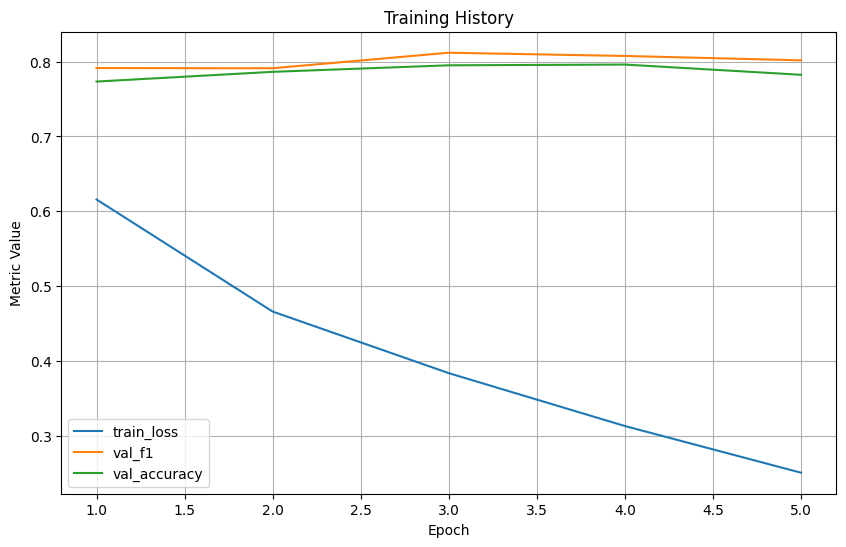

In [ ]:
draw_stats(stats=statistic, start_from=0)

In [ ]:
# plt.title("History")
# plt.plot(t_logloss, label="Log Loss History")
# plt.plot(t_loss, label="Loss History")
# plt.plot(t_accuracy, label="Accuracy history")
# plt.legend(loc="upper left")
# plt.show()

In [ ]:
# def predict(text, model, tokenizer, perplexity_model, device):
#     model.eval()

#     # Токенизация текста
#     encoding = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=64)
#     input_ids = encoding["input_ids"].to(device)
#     attention_mask = encoding["attention_mask"].to(device)

#     # Подсчёт перплексии
#     with torch.no_grad():
#         perplexity = get_perplexity(text)
#         perplexity_tensor = torch.tensor([perplexity], dtype=torch.float).to(device)

#         # Предсказание
#         with torch.no_grad():
#             logits = model(input_ids, attention_mask, perplexity_tensor)
#             probs = torch.softmax(logits, dim=1)
#             predicted_class = torch.argmax(probs, dim=1).item()

#     return predicted_class, probs.squeeze().tolist()


## EVALUATION

In [ ]:
eval_data = pd.read_json(os.path.join(DATA_DIR, 'data_final_for_dls_eval_new.jsonl'), orient='orient', lines=True)
eval_data = eval_data[eval_data['relevance'] != 0.1]
eval_data = eval_data.fillna("")
# data = data[:100]
eval_data

In [ ]:
raise

RuntimeError: No active exception to reraise

In [ ]:
def predict(text, model, tokenizer, device):
    model.eval()

    # Токенизация
    encoding = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=64).to(device)
    input_ids = encoding["input_ids"]
    attention_mask = encoding["attention_mask"]

    # Предсказание
    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        probs = torch.softmax(logits, dim=1)
        predicted_class = torch.argmax(probs, dim=1).item()

    # return predicted_class, probs.squeeze().tolist()
    return predicted_class, probs


In [ ]:
def predict_single(model, tokenizer, text, threshold=0.5, device='cpu'):
    model.eval()
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512).to(device)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model.to(device)

    with torch.no_grad():
        logits = model(**inputs)
        probs = torch.sigmoid(logits)
        pred = (probs > threshold).int()

    # print("Пример текста:", text)
    # print('# ' * 10)
    # print("Tokenized:", tokenizer(text))
    # print("Logits:", logits)
    # print("Probability:", probs)
    # print("Pred:", pred)


    return pred.item(), probs.item()


In [ ]:
test_row = data.iloc[5]
test_row


Text                              где в ростове на дону на северном можно сделат...
address                           Ростов-на-Дону, микрорайон Северный, проспект ...
name                              Институт эстетической медицины Sky Clinic; Ins...
normalized_main_rubric_name_ru                                         Косметология
permalink                                                               10404163869
prices_summarized                 Институт эстетической медицины Sky Clinic пред...
relevance                                                                       0.0
reviews_summarized                Общий обзор отзывов: Институт эстетической мед...
Name: 6, dtype: object

In [ ]:
text = combine_fields(test_row)
text

'Запрос: где в ростове на дону на северном можно сделать мрт | Название: Институт эстетической медицины Sky Clinic; Institute of Aesthetic Medicine Sky Clinic; Sky Clinic | Рубрика: Косметология | Описание: Институт эстетической медицины Sky Clinic предлагает широкий спектр косметологических услуг, включая чистки лица, массажи, пилинги, лазерные процедуры, нитевой лифтинг, плазмолифтинг, мезотерапию, а также консультации врачей | чистка лица | массаж лица | пилинг | лазерное омоложение | нитевой лифтинг | плазмолифтинг | мезотерапия | консультация дерматолога | удаление новообразований | пересадка волос | Отзывы: Общий обзор отзывов: Институт эстетической медицины Sky Clinic занимается косметологией и пластической хирургией. Тональность отзывов преимущественно положительная: пациенты хвалят профессионализм врачей, качество услуг, чистоту и сервис. Некоторые клиенты отмечают удобное расположение и наличие парковки. Критикуется один случай неудачной процедуры.\n\nСуммаризация 1: Пациенты

In [ ]:
preds, probs = predict_single(model, tokenizer, text)
preds, probs

(1, 0.9629009366035461)

In [ ]:
predicted_class, probs, logits = predict(text, model, tokenizer, device)
predicted_class, probs, logits

(0, tensor([[1.]], device='cuda:0'), tensor([[0.7874]], device='cuda:0'))

In [ ]:
test_data = data.sample(n=20, random_state=2026)
test_data

,Text,address,name,normalized_main_rubric_name_ru,permalink,prices_summarized,relevance,reviews_summarized
114,баллон углекислотный 10 л,"Московская область, Ленинский городской округ,...",Центрогаз-Беседы; Centrogas; Центрогаз,Технические и медицинские газы,35266366505,Центрогаз-Беседы предлагает технические и меди...,1.0,Организация занимается продажей и обменом газо...
11,белорусские кухни зов в москве официальный сай...,"Москва, Волгоградский проспект, 132",Кухни Зов; Zov; Зов; Зов Кухни; Kuhni-zov,Мебель для кухни,127861447693,Компания «Кухни Зов» предлагает разнообразные ...,0.0,Организация занимается изготовлением кухонь и ...
5,сеть быстрого питания,"Санкт-Петербург, 1-я Красноармейская улица, 15",Rostic's; KFC; Ресторан быстрого питания KFC,Быстрое питание,1219173871,Rostic's предлагает различные наборы быстрого ...,1.0,"Организация занимается быстрым питанием, предо..."
19,палаты в москве доступные для посещения,"Москва, Ивановская площадь",Московский Кремль; Moscow Kremlin; Маскоўскі К...,Музей,1023322799,,0.0,Московский Кремль — главная достопримечательно...
102,пропан агзс,"Москва, Загородное шоссе, 18А, стр. 2",Научно-исследовательский клинический институт ...,НИИ,1102813333,,0.0,Научно-исследовательский клинический институт ...
14,Катетеры баллонные дилатационные купить,"Санкт-Петербург, Светлановский проспект, 60, к...",Медтехника-1; Medtechnika-1; Medtech-1; Medteh...,Товары для здоровья,1281392839,Медтехника-1 предлагает средства реабилитации ...,0.0,Организация занимается продажей товаров для зд...
9,где в рязани можно купить бутафорские деньги,"Рязань, улица Кудрявцева, 56","Газпромбанк; Gazprombank; Газпромбанк, операци...",Банк,1251893227,,0.0,"Газпромбанк предоставляет банковские услуги, н..."
98,Макларен казахстан,"Омск, Нефтезаводская улица, 49к5",Макларен; Maklaren,"Автосервис , автотехцентр",166073734206,,1.0,Организация занимается ремонтом и обслуживание...
92,лучший грузинский ресторан спб,"Санкт-Петербург, Варшавская улица, 94",Чито Гврито; Chito-Gvrito; Ресторан грузинской...,Ресторан,1230962813,Ресторан «Чито Гврито» предлагает разнообразны...,1.0,Организация занимается подачей грузинских блюд...
22,Прачечная,"Свердловская область, Екатеринбург, Посадская ...",Мистер Ландри; Mister Landry,Химчистка,1536720670,Организация предоставляет услуги по стирке и х...,1.0,Организация занимается услугами химчистки и пр...


In [ ]:
for i, row in test_data.iterrows():
    text = combine_fields(row)
    # pred1, prob1 = predict(text, model, tokenizer, device)
    pred2, prob2 = predict_single(model, tokenizer, text, device=device)
    print(f"{row['relevance']} / {pred2}: {prob2}")

1.0 / 1: 0.9358146786689758
0.0 / 0: 0.03273127228021622
1.0 / 1: 0.9750092625617981
0.0 / 1: 0.9629009366035461
0.0 / 0: 0.04964868724346161
0.0 / 0: 0.4745849072933197
0.0 / 1: 0.9629009366035461
1.0 / 1: 0.9629009366035461
1.0 / 1: 0.8752132058143616
1.0 / 1: 0.9428630471229553
1.0 / 1: 0.9776723980903625
1.0 / 1: 0.9629009366035461
1.0 / 1: 0.9629009366035461
1.0 / 1: 0.9629009366035461
1.0 / 1: 0.9629009366035461
0.0 / 1: 0.9629009366035461
1.0 / 1: 0.9629009366035461
0.0 / 0: 0.023964405059814453
1.0 / 1: 0.6715292930603027
1.0 / 1: 0.9629009366035461


In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def plot_threshold_metrics(y_true, y_probs):
    # ROC
    fpr, tpr, thresholds_roc = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    # PR curve
    precision, recall, thresholds_pr = precision_recall_curve(y_true, y_probs)

    # Plot ROC
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title("ROC Curve")
    plt.legend()

    # Plot Precision-Recall
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label="PR Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Найти оптимальный threshold по максимальному F1
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds_pr[best_idx]

    print(f"🎯 Оптимальный threshold по F1: {best_threshold:.4f}")
    print(f"🔁 Precision: {precision[best_idx]:.4f} | Recall: {recall[best_idx]:.4f} | F1: {f1_scores[best_idx]:.4f}")
    return best_threshold


In [ ]:
for i in val_loader:
    print(i)
    break

{'input_ids': tensor([[    0,     0,     0,  ...,  1649,  5418,  6814],
        [  280,   317,   281,  ...,  5852,   547,  6715],
        [    0,     0,     0,  ...,   289, 13286,    18],
        ...,
        [    0,     0,     0,  ..., 10360,   668, 18081],
        [ 1032,  4922,   313,  ...,   294, 20038,    18],
        [    0,     0,     0,  ...,   368,  5322,  2682]]), 'attention_mask': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]]), 'labels': tensor([1., 1., 1., 1., 0., 0., 0., 1.])}


In [ ]:
y_true = []
y_probs = []

model.eval()
with torch.no_grad():
    for i, batch in data.iterrows():  # или просто список текстов + метки
        text = combine_fields(batch)  # или собранный шаблон
        label = batch['relevance']
        
        # tokenizer(...) → predict_single or batched logic
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        logits = model(**inputs)
        prob = torch.sigmoid(logits).cpu().numpy().flatten()[0]

        y_probs.append(prob)
        y_true.append(label)


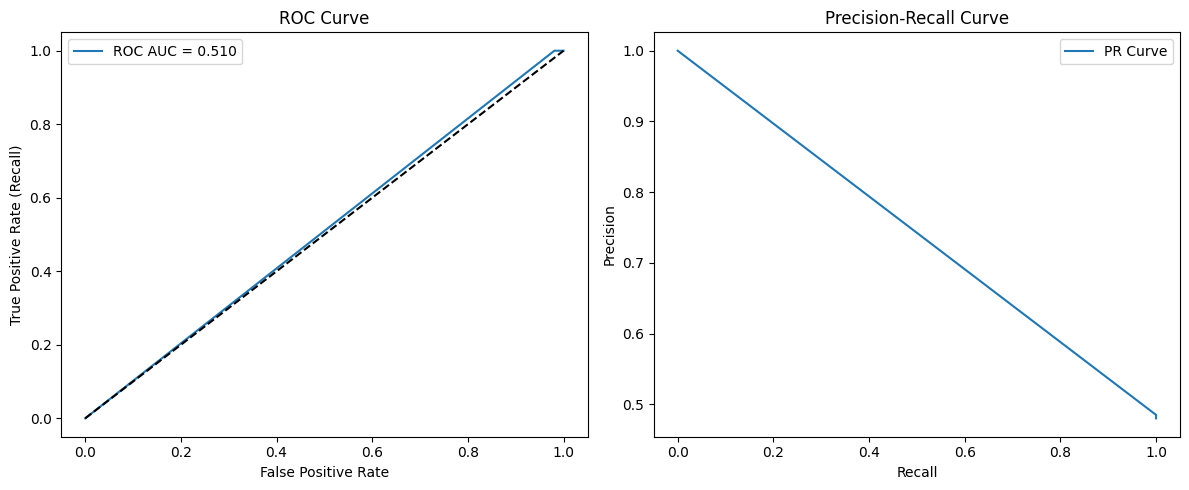

🎯 Оптимальный threshold по F1: 0.9629
🔁 Precision: 0.4848 | Recall: 1.0000 | F1: 0.6531


In [ ]:
best_threshold = plot_threshold_metrics(y_true, y_probs)

In [ ]:
raise

In [ ]:
# У тебя должно быть что-то такое:
perplexity_model = AutoModelForCausalLM.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2").to(device)
perplexity_tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2")

# Затем вызывай predict так:
label, prob = predict(
    text,
    model=model,  # твой классификатор
    tokenizer=tokenizer,  # токенизатор классификатора
    perplexity_model=perplexity_model,  # языковая модель!
    perplexity_tokenizer=perplexity_tokenizer,
    device=device
)

print(label, prob)

In [ ]:
tqdm.pandas()  # активирует tqdm для pandas

In [ ]:
def load_test_data(data_file: str, labels_file: str):
    df_info = pd.read_csv(labels_file)

    with open(data_file, "r", encoding="utf-8") as f:
        data = json.load(f)

    all_texts = []
    ids = []

    for _, row in df_info.iterrows():
        dialog_id = row["dialog_id"]
        participant_index = str(row["participant_index"])
        messages = data[dialog_id]

        texts = [
            m["text"] for m in messages if m["participant_index"] == participant_index
        ]
        combined_text = " ".join(texts)
        all_texts.append(combined_text)
        ids.append(row["ID"])

    df = pd.DataFrame({"ID": ids, "text": all_texts})
    return df

In [ ]:
df_test = load_test_data(f"{PROJECT_DIR}/you-are-bot/test.json", f"{PROJECT_DIR}/you-are-bot/ytest.csv")

In [ ]:
df = df_test.copy()

In [ ]:
def process_row(row):
    predicted_class, probs = predict(
    row['text'],
    model=model,  # твой классификатор
    tokenizer=tokenizer,  # токенизатор классификатора
    perplexity_model=perplexity_model,  # языковая модель!
    perplexity_tokenizer=perplexity_tokenizer,
    device=device
)
    return pd.Series([predicted_class, probs[1]])

In [ ]:
df[['preds', 'probs']] = df.progress_apply(process_row, axis=1)

In [ ]:
df['preds'] = df['preds'].astype('int')

In [ ]:
df

In [ ]:
# preds_df = pd.DataFrame({"ID": df["ID"], "is_bot": df['probs']})
# preds_df.to_csv("preds.csv", index=False)